<div style="text-align:right;">Justine Charrel - Master 1 Internship</div>

This script collocate the data of the MOSAiC campaign's radiosoundings and of the ERA5's reanalyses for one radiosounding. 

It can plot temperature, relative humidity, u, v, wind direction and wind speed of both. 

This scrip is used in a bash script to reproduce figures and collocated data for multiple radiosoundings.

### IMPORT

In [1]:
import numpy as np
from netCDF4 import Dataset as ncfile
from netCDF4 import num2date
import matplotlib.dates as dates
import datetime
import os

### READ DATA

In [2]:
date_min = '20200220000000'
date_max = '20200929180000'
task_ID = 4 #$TASK_ID

In [3]:
"""Function that create a list of dates and take the date corresponding to the index giving by the bash script."""
def task_date(date_min, date_max, task_ID):
    current_date = datetime.datetime.strptime(date_min, '%Y%m%d%H%M%S')
    end_date = datetime.datetime.strptime(date_max, '%Y%m%d%H%M%S')
    list_date = []
    while current_date <= end_date:
        list_date.append(current_date.strftime('%Y%m%d%H%M%S'))
        current_date = current_date + datetime.timedelta(hours = 6)
    date_task = list_date[task_ID - 1]
    return(date_task)

In [4]:
date_task = task_date(date_min,date_max,task_ID)

In [5]:
date_task

'20200220180000'

In [6]:
year=date_task[0:4] ; month=date_task[4:6] ; day=date_task[6:8] ; hour=date_task[8:10]

ppidir_era5 = '/lustre/storeB/users/maltem/Arctic/MOSAiC/ERA5/'
if (year=='2019') and (month=='10' or month=='11' or month=='12') :
    era5_link  = ppidir_era5 + 'ERA5_CentralArctic_PL_Radiosonde_Oct-Dec2019.nc'
elif (year=='2020') and (month=='01' or month=='02' or month=='03') :
    era5_link  = ppidir_era5 + 'ERA5_CentralArctic_PL_Radiosonde_Jan-Mar2020.nc'
elif (year=='2020') and (month=='04' or month=='05' or month=='06' or month=='07' or month=='08' or month=='09') :
    era5_link  = ppidir_era5 + 'ERA5_EuropeanArctic_PL_Radiosonde_April-Sep2020.nc'
else :
    print('no data available with ERA5 for this date')

ppidir_mosaic = '/lustre/storeB/users/maltem/Arctic/MOSAiC/radiosondes/'+year+'/'+month+'/'

mosaic_link  = ppidir_mosaic + 'PST-RS-01_2_RS41-GDP_001_'+year+month+day+'T'+hour+'0000_1-000-001.nc'
if os.path.isfile(mosaic_link) == False:
    mosaic_link  = ppidir_mosaic + 'PST-RS-01_2_RS41-GDP_001_'+year+month+day+'T'+hour+'0000_1-000-002.nc'
if os.path.isfile(mosaic_link) == False:
    mosaic_link  = ppidir_mosaic + 'PST-RS-01_2_RS41-GDP_001_'+year+month+day+'T'+hour+'0000_1-000-003.nc'
    
era5 = ncfile(era5_link,'r')        #dataset of radiosoundings of ERA5
mosaic = ncfile(mosaic_link,'r')    #dataset of radiosoundings of MOSAiC

In [7]:
# ----- RADIOSOUNDINGS REANALYSES ERA5 -----
era5_lat = era5.variables['latitude'][:]
era5_lon = era5.variables['longitude'][:]
era5_pres = era5.variables['level'][:]
era5_time = era5.variables['time'][:]

In [8]:
# ----- RADIOSOUNDINGS MOSAiC -----
mosaic_lat = mosaic.variables['lat'][:]
mosaic_lon = mosaic.variables['lon'][:]
mosaic_pres = mosaic.variables['press'][:]
mosaic_time = mosaic.variables['time'][:]

In [9]:
"""
# To calculate the distance traveled by the balloon

def great_circle_distance(lon1, lat1, lon2, lat2):
        # Convert from degrees to radians
        pi = 3.14159265
        lon1 = lon1 * 2 * pi / 360.
        lat1 = lat1 * 2 * pi / 360.
        lon2 = lon2 * 2 * pi / 360.
        lat2 = lat2 * 2 * pi / 360.
        dlon = lon2 - lon1
        dlat = lat2 - lat1
        a = np.sin(dlat / 2.) ** 2 + np.cos(lat1) * np.cos(lat2) * np.sin(dlon / 2.) ** 2
        c = 2 * np.arcsin(np.sqrt(a))
        distance = 6.371e6 * c
        return distance
    
great_circle_distance(mosaic_lon[0], mosaic_lat[0], mosaic_lon[-1], mosaic_lat[-1])
"""

'\n# To calculate the distance traveled by the balloon\n\ndef great_circle_distance(lon1, lat1, lon2, lat2):\n        # Convert from degrees to radians\n        pi = 3.14159265\n        lon1 = lon1 * 2 * pi / 360.\n        lat1 = lat1 * 2 * pi / 360.\n        lon2 = lon2 * 2 * pi / 360.\n        lat2 = lat2 * 2 * pi / 360.\n        dlon = lon2 - lon1\n        dlat = lat2 - lat1\n        a = np.sin(dlat / 2.) ** 2 + np.cos(lat1) * np.cos(lat2) * np.sin(dlon / 2.) ** 2\n        c = 2 * np.arcsin(np.sqrt(a))\n        distance = 6.371e6 * c\n        return distance\n    \ngreat_circle_distance(mosaic_lon[0], mosaic_lat[0], mosaic_lon[-1], mosaic_lat[-1])\n'

### CONVERT TIME

In [10]:
"""Function that convert times of a dataset depemding on its unit and calendar 
type to a datetime then to Matplotlib dates.
---exemple---
ERA5 :  'hours since 1900-01-01 00:00:00.0' become datetime of type 2019-10-01 00:00:00 then 18170
MOSAiC : 'seconds since 2019-10-31T22:55:09.757Z' become datetime of type 2019-10-31 22:55:09.757000 then 18200.954974039352
"""
def convert_time(dataset) :
    dataset_time = dataset.variables['time']
    t_unit = dataset_time.units
    t_cal = dataset_time.calendar
    dataset_nctime=[]; 
    dataset_nctime.append(num2date(dataset_time,units = t_unit,calendar = t_cal, only_use_python_datetimes=True, only_use_cftime_datetimes=False)) #datetime of type 2019-10-01 00:00:00
    #dates.date2num --> convert datetime objects to Matplotlib dates (better for compare ERA5 and MOSAiC times and for figures)
    #np.squeeze --> pass Matplotlib dates in column instead of in line
    dataset_nctimenum = np.squeeze(dates.date2num(dataset_nctime))
    return dataset_nctime,dataset_nctimenum,t_unit

In [11]:
era5_nctime,era5_nctimenum, t_unit = convert_time(era5)
mosaic_nctime, mosaic_nctimenum, t_unit = convert_time(mosaic)

### CORRESPONDING INDEXES OF LATITUDE, LONGITUDE, TIME AND OF PRESSURE LEVELS BETWEEN ERA5 AND MOSAIC

In [12]:
"""Function that finds the indexes of the closest values between ERA5 and MOSAiC.
   Useful for:
- keep the latitudes, longitudes and times of ERA5 corresponding to MOSAiC
- keep the MOSAiC pressure levels corresponding to ERA5"""
def corresponding_index(era5,mosaic) :
    diff = np.absolute(era5-mosaic)
    indx = diff.argmin()
    return indx

In [13]:
desired_levels = list(range(300, 1025, 25)) #from 300 hPa to 1000 hPa by 25 hPa
#desired_levels=era5_pres #if we want the same levels as ERA5 simply decomment this line

In [14]:
# Considering a single MOSAiC time because radiosounding lasts 1h30. It's short enough for all radiosounding times to be close to the same ERA5 time [00:00, 6:00, 12:00, 18:00]
indx_time = corresponding_index(era5_nctimenum,mosaic_nctimenum[0])
    
# Indexes of MOSAiC pressure levels closest to the desired pressure levels
indx_level = []
for i in range(0,len(desired_levels)) :
    indx_level.append(corresponding_index(mosaic_pres,desired_levels[i]))

# Latitude and longitude of ERA5 closest to MOSAiC

#considering only the latitude and longitude of the first point of MOSAiC
#indx_lat = corresponding_index(era5_lat,mosaic_lat[0])
#indx_lon = corresponding_index(era5_lon,mosaic_lon[0])

#considering the latitude and longitude of MOSAiC of each desired pressure level
indx_lat = []
for i in range(0,len(mosaic_lat[indx_level])) :
    indx_lat.append(corresponding_index(era5_lat,mosaic_lat[indx_level][i]))
indx_lon = []
for i in range(0,len(mosaic_lon[indx_level])) :
    indx_lon.append(corresponding_index(era5_lon,mosaic_lon[indx_level][i]))

In [15]:
mosaic_lat_collocated = mosaic_lat[indx_level]    #keep mosaic's latitudes of each desired pressure level
mosaic_lon_collocated = mosaic_lon[indx_level]    #keep mosaic's longitudes of each desired pressure level
mosaic_time_collocated = mosaic_time[indx_level]  #keep mosaic's times of each desired pressure level

era5_lat_collocated = era5_lat[indx_lat] #latitude closest to mosaic
era5_lon_collocated = era5_lon[indx_lon] #longitude closest to mosaic

### CORRESPONDING TEMPERATURE, RELATIVE HUMIDITY, ZONAL WIND U, MERIDIONAL WIND V, WIND DIRECTION AND WIND SPEED OF ERA5 AND MOSAIC

In [16]:
# MOSAiC

mosaic_temp = mosaic.variables['temp'][indx_level]
mosaic_rh = mosaic.variables['rh'][indx_level]
mosaic_u = mosaic.variables['wzon'][indx_level]
mosaic_v = mosaic.variables['wmeri'][indx_level]
mosaic_wdir = mosaic.variables['wdir'][indx_level]
mosaic_wspeed = mosaic.variables['wspeed'][indx_level]

In [17]:
# ERA5

#considering only the latitude and longitude of the first point of MOSAiC
#era5_temp = era5.variables['t'][indx_time,:,indx_lat,indx_lon]
#era5_rh = era5.variables['r'][indx_time,:,indx_lat,indx_lon]
#era5_u = era5.variables['u'][indx_time,:,indx_lat,indx_lon]
#era5_v = era5.variables['v'][indx_time,:,indx_lat,indx_lon]
#era5_wdir = ((180/np.pi) * np.arctan2(era5_u, era5_v) + 180) % 360
#era5_wspeed = np.sqrt(era5_u**2+era5_v**2)

#considering latitude and longitude of each pressure level
era5_pres_list=era5_pres.tolist()
era5_pres_list_cut = era5_pres_list[era5_pres_list.index(desired_levels[0]):]

"""Function that finds the values of t, rh, u and v corresponding to the desired pressure levels.
It add a value when the pressure level isn't available in ERA5.
This value is the mean between the two closest surrounding pressure levels"""


def interpolate() :
    era5_temp = [] ; era5_rh = [] ; era5_u = [] ; era5_v = [] ; err=0
    for i in range(0, len(indx_lat)) :
        print('i',i)
        
        if era5_pres_list_cut[i] not in desired_levels :
            print('problem', era5_pres_list_cut[i])
            del(era5_pres_list_cut[i])
            print(era5_pres_list_cut)
            err=err+1
            ind = era5_pres_list.index(desired_levels[i])+err
            print('ind',ind)
            t = era5.variables['t'][indx_time][ind][indx_lat[i]][indx_lon[i]]
            era5_temp.append(t)
            rh = era5.variables['r'][indx_time][ind][indx_lat[i]][indx_lon[i]]
            era5_rh.append(rh)
            u = era5.variables['u'][indx_time][ind][indx_lat[i]][indx_lon[i]]
            era5_u.append(u)
            v = era5.variables['v'][indx_time][ind][indx_lat[i]][indx_lon[i]]
            era5_v.append(v)
        
        elif desired_levels[i] in era5_pres_list_cut :
            ind = era5_pres_list.index(desired_levels[i])+err
            print('elif, ind, dl, ifs', ind, desired_levels[i], era5_pres_list_cut[i])
            t = era5.variables['t'][indx_time][ind][indx_lat[i]][indx_lon[i]]
            era5_temp.append(t)
            rh = era5.variables['r'][indx_time][ind][indx_lat[i]][indx_lon[i]]
            era5_rh.append(rh)
            u = era5.variables['u'][indx_time][ind][indx_lat[i]][indx_lon[i]]
            era5_u.append(u)
            v = era5.variables['v'][indx_time][ind][indx_lat[i]][indx_lon[i]]
            era5_v.append(v)

        else :
            era5_pres_list_cut.insert(i,desired_levels[i])
            print(era5_pres_list_cut)
            ind = era5_pres_list_cut.index(desired_levels[i])+err
            print('else, ind, dl, ifs', ind, desired_levels[i],era5_pres_list_cut[i])
            t = era5.variables['t'][indx_time][ind][indx_lat[i+1]][indx_lon[i+1]]
            era5_temp.insert(i,(np.mean([era5_temp[i-1],t])))
            rh = era5.variables['r'][indx_time][ind][indx_lat[i+1]][indx_lon[i+1]]
            era5_rh.insert(i,(np.mean([era5_rh[i-1],rh])))
            u = era5.variables['u'][indx_time][ind][indx_lat[i+1]][indx_lon[i+1]]
            era5_u.insert(i,(np.mean([era5_u[i-1],u])))
            v = era5.variables['v'][indx_time][ind][indx_lat[i+1]][indx_lon[i+1]]
            era5_v.insert(i,(np.mean([era5_v[i-1],v])))
            err=err-1
            
        print(era5_temp)
    print(era5_pres_list_cut)
    return era5_temp, era5_rh, era5_u, era5_v

In [18]:
# ERA5

#considering only the latitude and longitude of the first point of MOSAiC
#era5_temp = era5.variables['t'][indx_time,:,indx_lat,indx_lon]
#era5_rh = era5.variables['r'][indx_time,:,indx_lat,indx_lon]
#era5_u = era5.variables['u'][indx_time,:,indx_lat,indx_lon]
#era5_v = era5.variables['v'][indx_time,:,indx_lat,indx_lon]
#era5_wdir = ((180/np.pi) * np.arctan2(era5_u, era5_v) + 180) % 360
#era5_wspeed = np.sqrt(era5_u**2+era5_v**2)

#considering latitude and longitude of each pressure level
era5_pres_list=era5_pres.tolist()
era5_pres_list_cut = era5_pres_list[era5_pres_list.index(desired_levels[0]):]

"""Function that finds the values of t, rh, u and v corresponding to the desired pressure levels.
It add a value when the pressure level isn't available in ERA5.
This value is the mean between the two closest surrounding pressure levels"""
def interpolate() :
    era5_temp = [] ; era5_rh = [] ; era5_u = [] ; era5_v = []
    for i in range(0, len(indx_lat)) :
        if desired_levels[i] in era5_pres_list_cut :
            ind = era5_pres_list.index(desired_levels[i])
            t = era5.variables['t'][indx_time][ind][indx_lat[i]][indx_lon[i]]
            era5_temp.append(t)
            rh = era5.variables['r'][indx_time][ind][indx_lat[i]][indx_lon[i]]
            era5_rh.append(rh)
            u = era5.variables['u'][indx_time][ind][indx_lat[i]][indx_lon[i]]
            era5_u.append(u)
            v = era5.variables['v'][indx_time][ind][indx_lat[i]][indx_lon[i]]
            era5_v.append(v)
        else :
            era5_pres_list_cut.insert(i,desired_levels[i])
            t = era5.variables['t'][indx_time][ind+1][indx_lat[i]][indx_lon[i]]
            era5_temp.insert(i,(np.mean([era5_temp[i-1],t])))
            rh = era5.variables['r'][indx_time][ind+1][indx_lat[i]][indx_lon[i]]
            era5_rh.insert(i,(np.mean([era5_rh[i-1],rh])))
            u = era5.variables['u'][indx_time][ind+1][indx_lat[i]][indx_lon[i]]
            era5_u.insert(i,(np.mean([era5_u[i-1],u])))
            v = era5.variables['v'][indx_time][ind+1][indx_lat[i]][indx_lon[i]]
            era5_v.insert(i,(np.mean([era5_v[i-1],v])))
    return era5_temp, era5_rh, era5_u, era5_v

In [19]:
era5_temp, era5_rh, era5_u, era5_v = interpolate()

In [20]:
era5_wdir = []
era5_wspeed = []
for i in range(0, len(indx_lat)) :
    era5_wdir.append(((180/np.pi) * np.arctan2(era5_u[i], era5_v[i]) + 180) % 360)
    era5_wspeed.append(np.sqrt(era5_u[i]**2+era5_v[i]**2))

### PLOT 

In [27]:
"""Function that plot the profiles of temperature, relative humidity, zonal wind u, meridional wind v, wind direction and wind speed of ERA5 and MOSAiC"""
def plotprofiles() :
    
    import matplotlib.gridspec as gridspec
    from matplotlib import pyplot as plt

    parameters = {'axes.labelsize':20, 'axes.titlesize':20, 'legend.fontsize':16, 'xtick.labelsize':20, 'ytick.labelsize':20, 
              'legend.title_fontsize':20, 'figure.titlesize':25}
    plt.rcParams.update(parameters)

    fig, axs = plt.subplots(1,6,figsize=(30,15))
    axs[0].plot(mosaic_temp,desired_levels, 'C0')
    axs[0].plot(era5_temp,desired_levels, 'C1')
    axs[0].invert_yaxis()
    axs[0].set_xlabel ('T [K]')
    axs[0].set_ylabel ('Pressure [hPa]')

    axs[1].plot(mosaic_rh, desired_levels, 'C0')
    axs[1].plot(era5_rh,desired_levels, 'C1')
    axs[1].invert_yaxis()
    axs[1].set_xlabel ('RH [%]')

    axs[2].plot(mosaic_u,desired_levels, 'C0')
    axs[2].plot(era5_u,desired_levels, 'C1')
    axs[2].invert_yaxis()
    axs[2].set_xlabel (r'u [$m.s^{-1}$]')

    axs[3].plot(mosaic_v,desired_levels, 'C0')
    axs[3].plot(era5_v,desired_levels, 'C1')
    axs[3].invert_yaxis()
    axs[3].set_xlabel (r'v [$m.s^{-1}$]')

    axs[4].plot(mosaic_wdir,desired_levels, 'C0')
    axs[4].plot(era5_wdir,desired_levels, 'C1')
    axs[4].set_xlabel ('Wind direction [degree]')
    axs[4].invert_yaxis()

    axs[5].plot(mosaic_wspeed,desired_levels, 'C0', label='MOSAiC')
    axs[5].plot(era5_wspeed,desired_levels, 'C1', label='ERA5')
    axs[5].invert_yaxis()
    axs[5].set_xlabel (r'Wind speed [$m.s^{-1}$]')
    
    date = day + '/' + month + '/' + year + ' ' + hour + ':' + date_task[10:12] + ':' + date_task[12:14]
    fig.legend()
    fig.suptitle(date, size=16)
    fig.tight_layout()
    fig.subplots_adjust(top=0.93)
    path_fig = '/lustre/storeB/users/justinec/master_internship/figures/era5_mosaic_profiles/'
    #plt.savefig(path_fig+'fig_profiles_tropo_'+date_task+'.png')

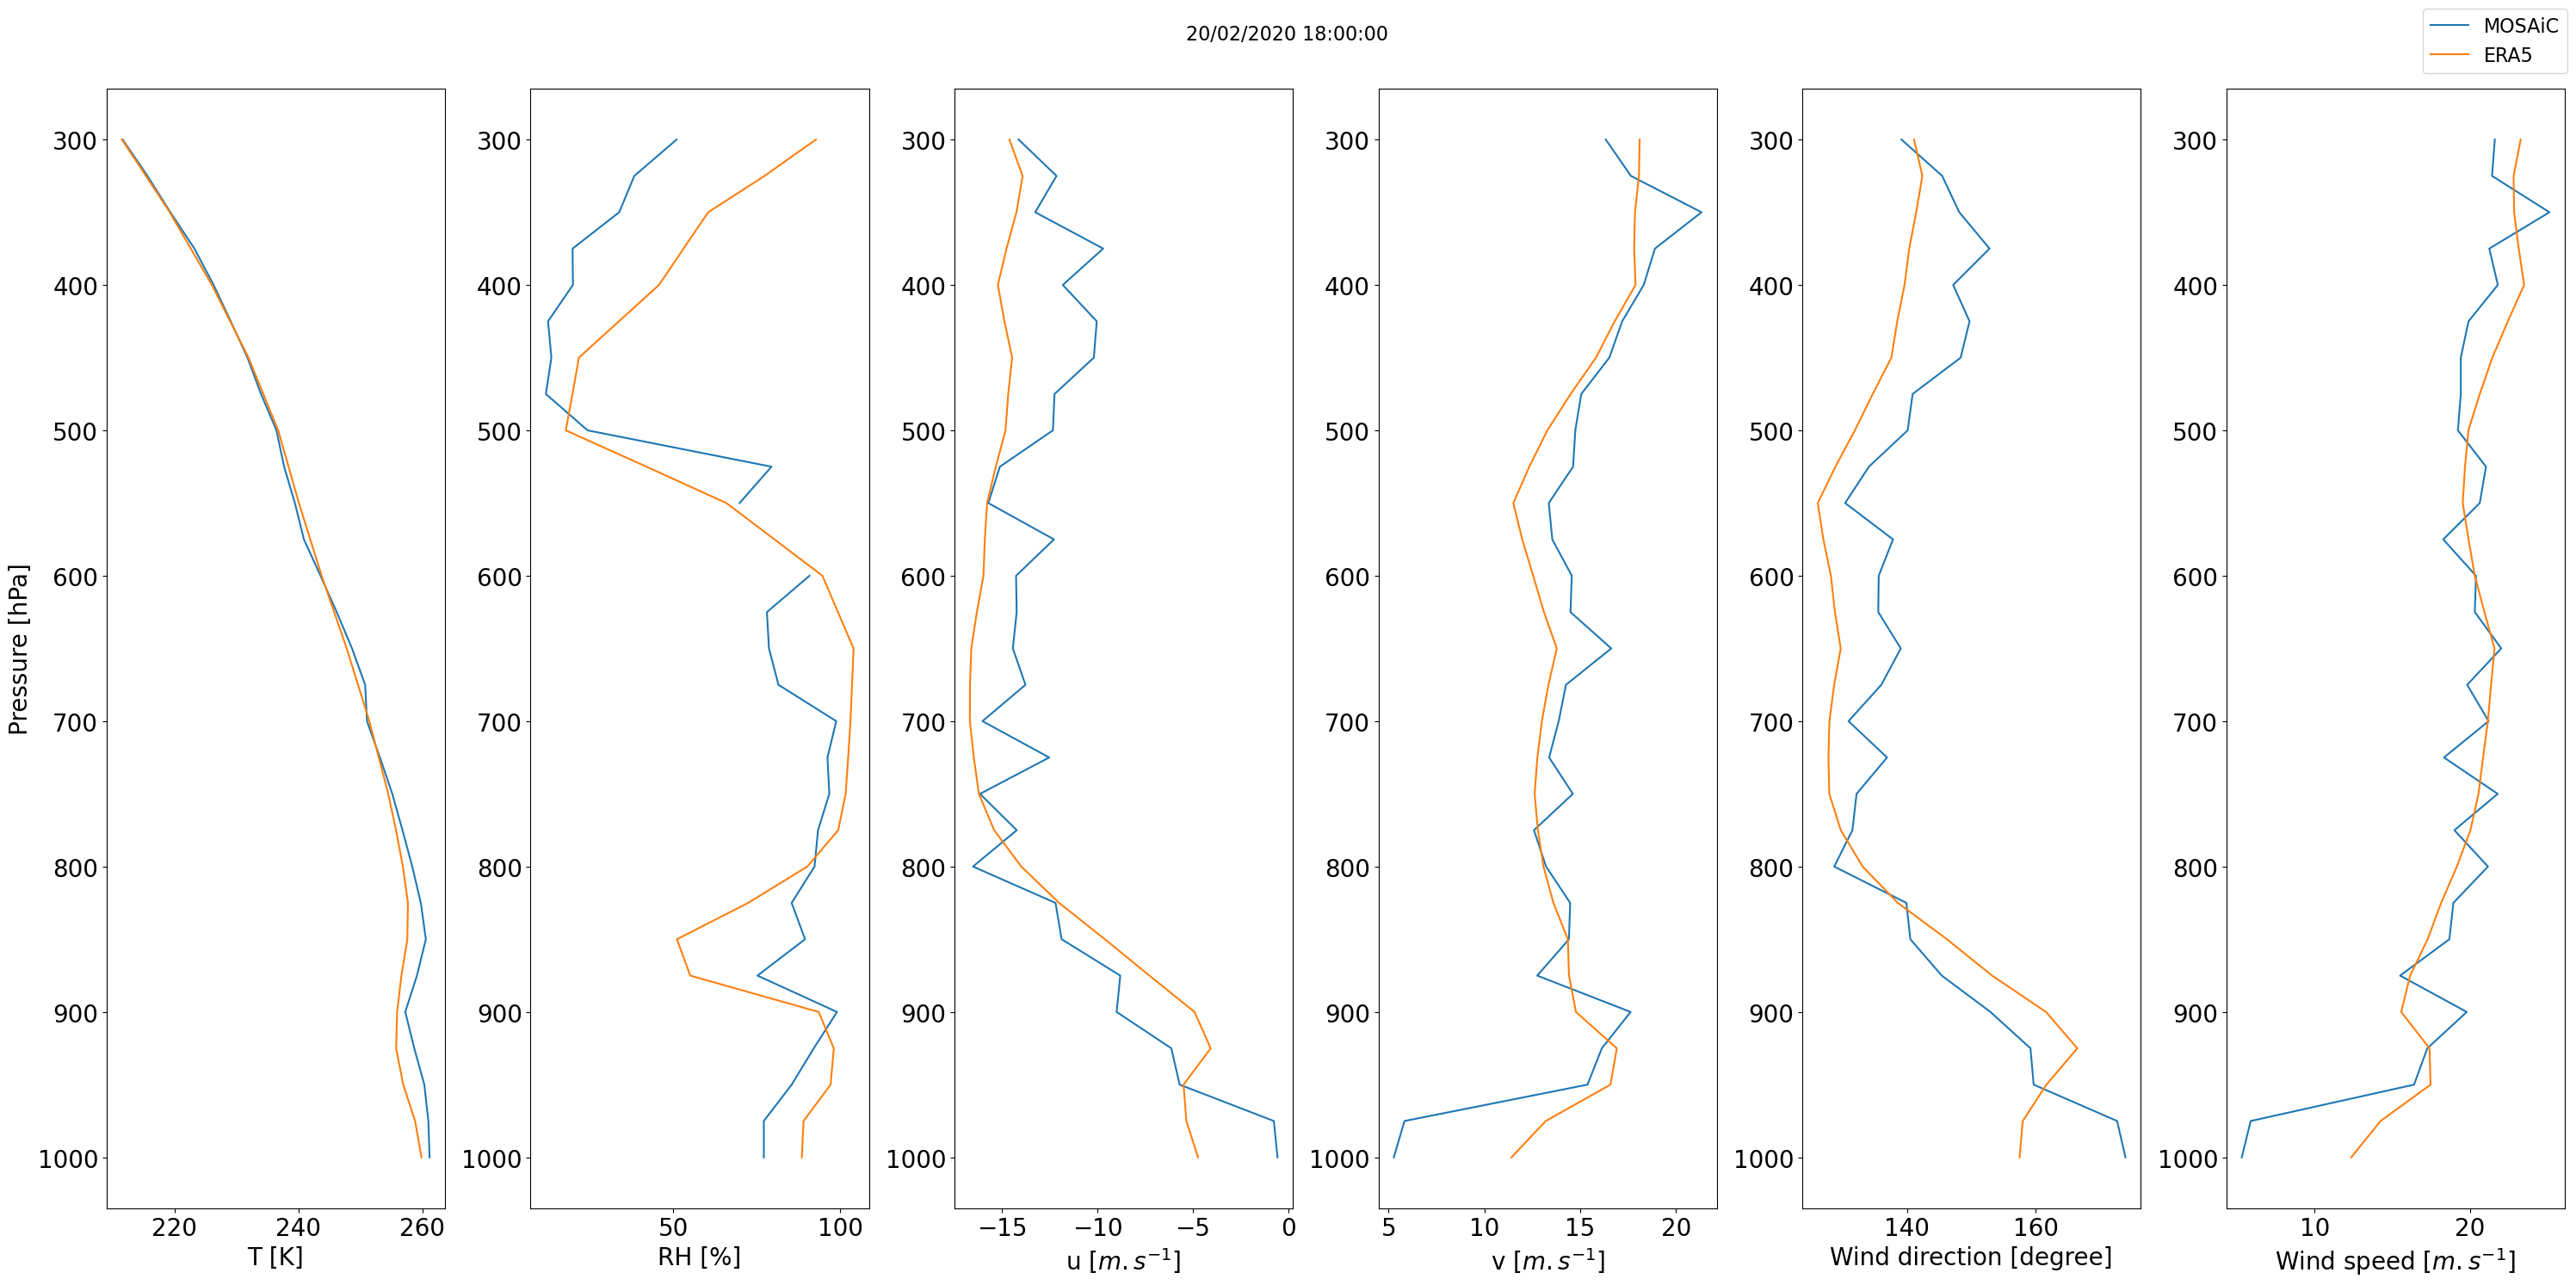

In [28]:
plotprofiles() #comment this line to not plot figure

### CREATE COLLOCATED NCFILE

In [28]:
# Create a ncfile in a path
path_output = '/lustre/storeB/users/justinec/master_internship/data/ERA5_MOSAiC/'
output_filename = path_output + year + '/' + month + '/collocated_ERA5_MOSAiC_' + date_task + '.nc'
output_netcdf = ncfile(output_filename, 'w', format = 'NETCDF4')

In [29]:
# Dimension
pres = output_netcdf.createDimension('pres',len(desired_levels))

In [30]:
# Variables
pres = output_netcdf.createVariable('pres', 'd', ('pres'))
temp_era5 = output_netcdf.createVariable('temp_era5', 'd', ('pres'))
temp_mosaic = output_netcdf.createVariable('temp_mosaic', 'd', ('pres'))
rh_era5 = output_netcdf.createVariable('rh_era5', 'd', ('pres'))
rh_mosaic = output_netcdf.createVariable('rh_mosaic', 'd', ('pres'))
wspeed_era5 = output_netcdf.createVariable('wspeed_era5', 'd', ('pres'))
wspeed_mosaic = output_netcdf.createVariable('wspeed_mosaic', 'd', ('pres'))
wdir_era5 = output_netcdf.createVariable('wdir_era5', 'd', ('pres'))
wdir_mosaic = output_netcdf.createVariable('wdir_mosaic', 'd', ('pres'))
lat_mosaic = output_netcdf.createVariable('lat_mosaic', 'd', ('pres'))
lon_mosaic = output_netcdf.createVariable('lon_mosaic', 'd', ('pres'))
time_mosaic = output_netcdf.createVariable('time_mosaic', 'd', ('pres'))

In [31]:
# Information
pres.units = 'millibars'
pres.long_name = 'Pressure level'
pres.standard_name = 'pressure_level'
temp_era5.units = 'K'
temp_era5.long_name = 'Temperature'
temp_era5.standard_name = 'air_temperature'
temp_mosaic.units = 'K'
temp_mosaic.long_name = 'Temperature'
temp_mosaic.standard_name = 'air_temperature'
rh_era5.units = 'percent'
rh_era5.long_name = 'Relative Humidity'
rh_era5.standard_name = 'relative_humidity'
rh_mosaic.units = 'percent'
rh_mosaic.long_name = 'Relative Humidity'
rh_mosaic.standard_name = 'relative_humidity'
wspeed_era5.units = 'm s-1'
wspeed_era5.long_name = 'Wind speed'
wspeed_era5.standard_name = 'wind_speed'
wspeed_mosaic.units = 'm s-1'
wspeed_mosaic.long_name = 'Wind speed'
wspeed_mosaic.standard_name = 'wind_speed'
wdir_era5.units = 'degree'
wdir_era5.long_name = 'Wind direction'
wdir_era5.standard_name = 'wind_from_direction'
wdir_era5.comment = 'Wind direction with 0°:north, 90°:east, 180°:south, 270°:west'
wdir_mosaic.units = 'degree'
wdir_mosaic.long_name = 'Wind direction'
wdir_mosaic.standard_name = 'wind_from_direction'
wdir_mosaic.comment = 'Wind direction with 0°:north, 90°:east, 180°:south, 270°:west'
lat_mosaic.units = 'degree_North'
lat_mosaic.long_name = 'Latitude'
lat_mosaic.standard_name = 'latitude'
lon_mosaic.units = 'degree_East'
lon_mosaic.long_name = 'Longitude'
lon_mosaic.standard_name = 'longitude'
time_mosaic.units = t_unit
time_mosaic.long_name = 'Time'
time_mosaic.standard_name = 'time'

In [32]:
# Assignment of variables
pres[:] = desired_levels
temp_era5[:] = era5_temp
temp_mosaic[:] = mosaic_temp
rh_era5[:] = era5_rh
rh_mosaic[:] = mosaic_rh
wspeed_era5[:] = era5_wspeed
wspeed_mosaic[:] = mosaic_wspeed
wdir_era5[:] = era5_wdir
wdir_mosaic[:] = mosaic_wdir
lat_mosaic[:] = mosaic_lat_collocated
lon_mosaic[:] = mosaic_lon_collocated
time_mosaic[:] = mosaic_time_collocated

In [33]:
output_netcdf.close() #close the netcdf file